# NN Momentum Regression


## Import

### Import modules

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas
import timeit #more accurate than time

import theano

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Dense, Activation
from keras.models import Sequential, model_from_json, load_model

import seaborn as sns
sns.set_style("white")
import os
import json

from six.moves import cPickle #Faster than pickle

import sys
sys.path.append('../modules/')
from MPPlot import *
from Processors import *

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


### Choose backend

In [2]:
import importlib

def set_keras_backend(backend):
    """
    Changes Keras backend
    
    Parameters
    ----------
    backend : str
              Backend wanted (theano or tensorflow)
              
    Returns
    -------
    """
    
    idm = {"theano": "th", "tensorflow": "tf"}
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
        keras.backend.set_image_dim_ordering(idm[backend])

set_keras_backend("theano")

## Import data

In [3]:
loc = "../data/"
data = pandas.read_csv(loc + "DS_1_electron_train.csv")
fullData = pandas.read_csv(loc + "DS_1_train.csv")
print("Samples contains {} events total".format(len(data)))

Samples contains 100 events total


In [4]:
data.head()

,event_id,P,X,Y,Z,TX,TY
0,43311,6.059411,50445.277344,18868.576172,32163.242188,-0.145684,-0.044486
1,44301,4.829437,44404.660156,24444.984375,10518.998047,-0.044544,0.132461
2,41829,4.929091,49269.140625,45781.617188,37460.796875,0.060940,0.101490
3,38613,1.587992,44798.660156,43921.625000,35979.109375,-0.332825,0.115194
4,18087,7.594307,45228.773438,43913.035156,28341.851562,0.021005,0.058128


In [5]:
fullData.head()

,index,event_id,X,Y,Z,TX,TY,chi2,signal
0,0,-999,42720.238281,75152.406250,32325.0,-0.475539,0.405506,2.652586,0.0
1,1,-999,46023.816406,37043.359375,21981.0,0.330822,-0.013988,2.497527,0.0
2,2,-999,52706.117188,33872.730469,16809.0,0.342634,-0.058724,2.120421,0.0
3,3,-999,47334.101562,9698.531250,60771.0,0.007868,-0.632822,0.618535,0.0
4,4,-999,67380.835938,19137.265625,37497.0,-0.212537,-0.192243,2.799303,0.0


### Process data and add new features

In [7]:
ids = data['event_id'].values
chi2 = []
for i, ID in enumerate(ids):
    chi2.append(fullData.loc[fullData.event_id == ID, 'chi2'].values[0])

In [8]:
data['chi2'] = pandas.Series(chi2, index=data.index)

### Feature sets

In [9]:
trainFeatures = ['X', 'Y', 'Z', 'TX', 'TY', 'chi2']

In [10]:
set0 = ['X', 'Y', 'Z', 'TX', 'TY']
set1 = trainFeatures
set2 = ['TX', 'TY', 'chi2']

### Training options
Here we define the way we'll train the classifier. For simplicity we'll just use the low-level final-state features. We can also choose what pre-processing step to apply to the data.

In [11]:
regTrainFeatures = set2 #The features used
regModel = "model0" #Will define the layout of the network
varSet = "set2" #Name of the feature set used, mainly for saving results
normIn = True #Whether we want to normalise and standardise the inputs
normOut = True #Whether we want to normalise and standardise the outputs
pca = True #Whether we want to use principal-component analysis to decorrelate inputs
whiten = False #Whether we want to whiten input data
normPCA = True #Whether we want to normalise and standardise the inputs after PCA
nSplits = 1 #Number of train/test splits to make during cross-validation
ensembleSize = 10 #Number of classifiers  to include in ensemble = min(nSplits, ensembleSize)
ensembleMode = 'AUC' #Metric used to weight classifiers in ensemble, I've found loss to quite relaible
compileArgs = {'loss':'mse', 
               'optimizer':'nadam'} #Loss function and optimiser for NN
trainParams = {'epochs' : 10000, 
               'batch_size' : 32, 
               'verbose' : 0} #Maximum epochs for training and size of mini-batch
print("Training on {} features {}". format(len(regTrainFeatures),[var for var in regTrainFeatures]))

Training on 3 features ['TX', 'TY', 'chi2']


## Pre-process data

Here we define a SK-Learn pipeline which will contain transformation steps for any data fed in. Pipelines are a nice, compact way of handing data transformations.

In [12]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
        if normPCA:
            stepsIn.append(('normPCA', StandardScaler()))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)

Next we fit the pipeline to the **development** data inputs. For compactness we also transform the development data and create Numpy arrays of the inputs and targets. **N.B.** The type of the inputs will normally be either float32 or float64. float32 is preferred, since speed and memory outweighs precision. Sometimes if the data is naturally in float64, the conversion to float32 can can result in NaNs or infs, so watch out.

In [13]:
X_reg = inputPipe.fit_transform(data[regTrainFeatures].values.astype('float32'))
y_reg = outputPipe.fit_transform(data['P'].values.astype('float32'))

/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/giles/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


## Define regressor

In [14]:
def getRegressor(model, nIn, nOut, compileArgs):
    regModel = Sequential()
    depth = None
    width = None
    if model == "model0":
        depth = 3
        width = 50
        regModel.add(Dense(width, input_dim=nIn, kernel_initializer='he_normal')) #First layer requires number of inputs
        regModel.add(Activation('relu')) #Add ReLU activation function
        for i in range(depth): #Continue to add hidden layers
            regModel.add(Dense(width, kernel_initializer='he_normal')) #Subsequent layers inherit input_dim from previous layer
            regModel.add(Activation('relu'))
    if model == "model1":
        depth = 3
        width = 100
        regModel.add(Dense(width, input_dim=nIn, kernel_initializer='he_normal')) #First layer requires number of inputs
        regModel.add(Activation(selu)) #Add ReLU activation function
        for i in range(depth): #Continue to add hidden layers
            regModel.add(Dense(width, kernel_initializer='he_normal')) #Subsequent layers inherit input_dim from previous layer
            regModel.add(Activation(selu))
    regModel.add(Dense(nOut, activation='linear', kernel_initializer='glorot_normal')) #Final layer requires one output
    regModel.compile(**compileArgs) #Compile the network graph to prepare it for use
    return regModel

### Callbacks

Callbacks are methods that can be called during training. They have a variety of uses such as monitoring training, stopping training early, and saving different versions of the model. Here we define our own callback,  which saves the history of the training.

We want to view the history of the model's performance on the training and testing data during data, however by default the training loss is averaged over the epoch, and the test loss is evaluated at the end of the epoch, so is not comparable. This modified version evaluates the performance on the training data at the end of each epoch.

Later well also use some other callbacks:

EarlyStopping monitors a specified metric and stops the training if the performance fails to improve for a specified number of epochs in a row. Here we use it to monitor the loss on the test data and stop when it doesn't improve after 10 epochs.

ModelCheckpoint is used to save the weights of the network during training. It's quite flexible, but here we use it save the model which performs best according to the loss in test data.

Normally during training, the test loss will reach a minimum and either saturate or start to increase (overtraining). The training loss will normally either saturate or continue to decrease. The optimum point is when the test-loss first reaches its minimum point. The combination of EarlyStopping and ModelCheckpoint acts to save the model at this point and allow some leeway in case it starts to decrease again.

In [15]:
class LossHistory(Callback):
    def __init__(self, trData):
        self.trainingData = trData
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingData[0], self.trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

## Train classifier

Now we're ready to train the classifier.

We use stratified k-fold cross-validation for training. This splits the full development data into *k* sets, trains the model on $k-1$ sets and tests its performance on the remainings set. This then continues *k* times with a different set being used for testing each time. The *stratified* part means that each set will contain the same fraction of event classes as the full dataset, which helps ensure unbiased training and means that our class weights will be valid.

During training we save each trained model, as well as its performance on the test set.

**N.B.** The model can either be saved directly, or by saving the weights and layout separately. The former is more compact, but doesn't handle custom objects well. If you've used a custom loss or activation function, the the second method is more flexible. It also seems to be quicker, but I've not done concrete tests...

In [16]:
start = timeit.default_timer()

model = None # Clearing the NN
model = getRegressor(regModel, len(regTrainFeatures), 1, compileArgs)
model.reset_states #Just checking

lossHistory = LossHistory((X_reg, y_reg))
earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, 
                           save_best_only=True, save_weights_only=True, mode='auto', period=1)

#Begin training the model
model.fit(X_reg, y_reg, validation_data = (X_reg, y_reg),
          callbacks = [earlyStop, saveBest, lossHistory], **trainParams)

model.load_weights("train_weights/best.h5") #Loads the best model saved by ModelCheckpoint

result = model.evaluate(X_reg, y_reg, verbose=0)

print("Score is:", result)
print("Training took {:.3f}s ".format(timeit.default_timer() - start))

model.summary() #Prints a summary of the model layout

Epoch 00125: early stopping
Score is: 0.0967306575179
Training took 7.931s 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_2 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_3 (Activation)    (None, 50)                0         
_________________________________________________________________


### Plot histories
Now let's plot the history of the training.

We can see that the test loss starts to decrease, reaches a minimum point, then begins to increase. The training loss continues to decrease. The early stopping detects the lack of imporvement in test loss and stops the training. The checkpoint allows us to use the state of the model at the minimum point of training loss.

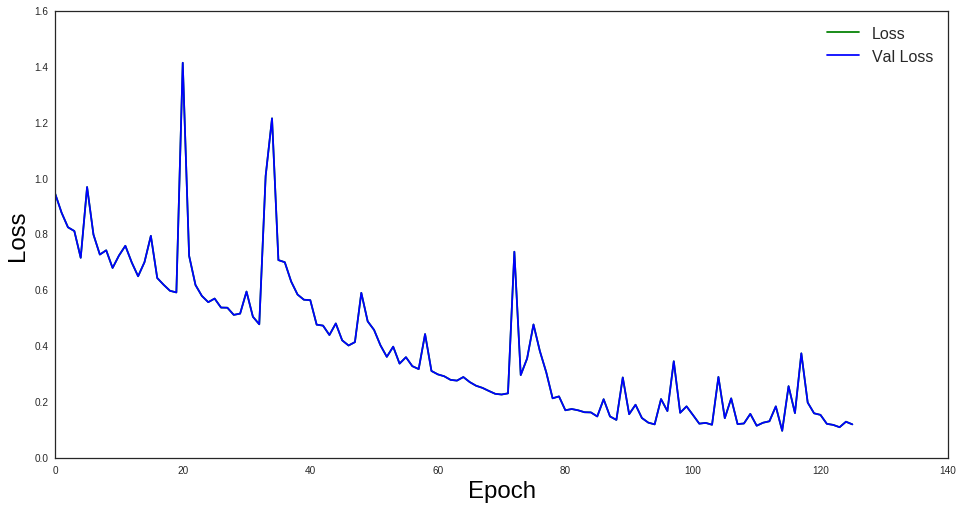

In [17]:
plt.figure(figsize=(16,8))

plt.plot(lossHistory.losses['loss'], color='g', label='Loss')
plt.plot(lossHistory.losses['val_loss'], color='b', label='Val Loss')
        
plt.legend(fontsize=16)
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("Loss", fontsize=24, color='black')
plt.show()

## Application

In [18]:
data['reg_P'] = outputPipe.inverse_transform(model.predict(
        inputPipe.transform(data[regTrainFeatures].values.astype('float32')), verbose=0))

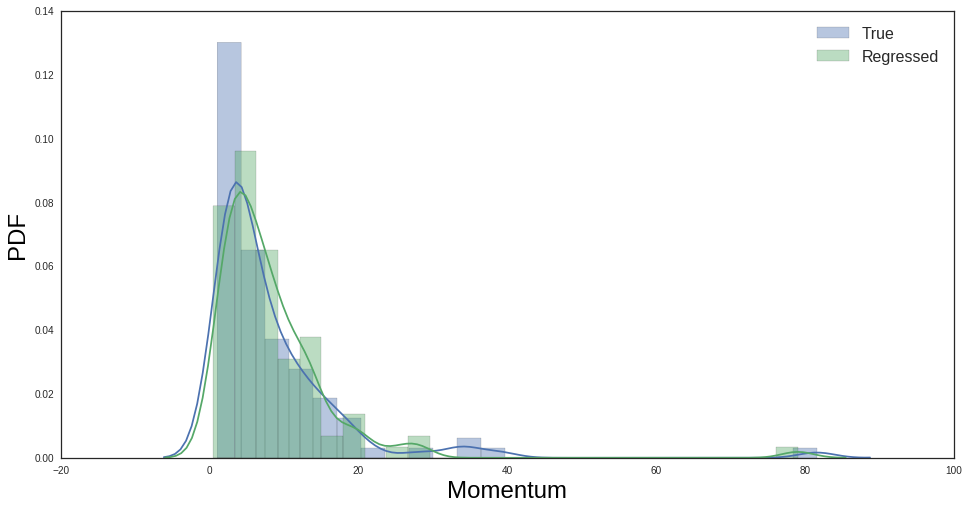

In [19]:
params = {'hist' : True, 'kde' : True, 'norm_hist' : True}
plt.figure(figsize=(16, 8))
sns.distplot(data['P'], label='True', **params)
sns.distplot(data['reg_P'], label='Regressed', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Momentum", fontsize=24, color='black')
plt.ylabel("PDF", fontsize=24, color='black')
plt.show()

## Save

In [20]:
name = "weights/NN_Regressor_2"
print(name)

weights/NN_Regressor_2


In [21]:
os.system("mkdir weights")
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
json_string = model.to_json()
open(name + ".json", 'wb').write(str.encode(json_string)) #Save layout as json
model.save_weights(name + '.h5') #Save weights as h5
with open(name + '_compile.pkl', 'w') as fout: #Save compile arguments; loaded model might need recompiling
    json.dump(compileArgs, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout: #Save the pre-processing pipeline
    cPickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'wb') as fout: #Save the pre-processing pipeline
    cPickle.dump(outputPipe, fout)

## Ensemble Size

### Construct ensemble
During the *k*-fold CV we trained *k* models. We could just use the best one, however it is unlikely to optimimum for all input possibilities. Ensembling is a method of using multiple classifiers together to achieve a better result than a single one on its own.

The method I use here is to weight the contributions of each classifier according to how well it performed on its test set during CV.

In [ ]:
results = None
with open('train_weights/resultsFile.pkl', 'rb') as fin: #Reload results in case notebook was closed
    results = cPickle.load(fin)

In [ ]:
def loadModel(cycle, location='train_weights/train_'): #Function to load a specified classifier
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [ ]:
def getWeights(value, met): #How the weight is calculated. Metrics configured such that lower values are better.
    return 1/value #Reciprocal of metric is a simple way of assigning larger weight s to better metrics

Now we order the classifiers by performance, load the required number, and weight them

In [ ]:
ensemble = []
weights = []

print("Choosing ensemble by", ensembleMode)
dtype = [('cycle', int), ('result', float)]
values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], 
                          dtype=dtype), order=['result'])

for i in range(min([ensembleSize, len(results)])):
    ensemble.append(loadModel(values[i]['cycle']))
    weights.append(getWeights(values[i]['result'], ensembleMode))
    print("Model {} is {} with {} = {}". format(i, values[i]['cycle'], ensembleMode, values[i]['result']))
    
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

### Response on dev data

Now let's apply the ensemble to the whole of the development data

#### Pre-process data

In [ ]:
X_dev = inputPipe.transform(devData[classTrainFeatures].values.astype('float32'))

#### Get response

In [ ]:
def predict(inData, ensemble, weights, n=-1): #Loop though each classifier and predict data class
    pred = np.zeros((len(inData), 1))
    if n == -1:
        n = len(ensemble)+1
    ensemble = ensemble[0:n] #Use only specified number of classifiers
    weights = weights[0:n]
    weights = weights/weights.sum() #Renormalise weights
    
    for i, model in enumerate(ensemble):
        pred += weights[i] * model.predict(inData, verbose=0)
        
    return pred

In [ ]:
pred = predict(X_dev, ensemble, weights)
devData['pred_class'] = pandas.Series(pred[:,0], index=devData.index) #Add predicted class to data

In [ ]:
devAUC = roc_auc_score(devData["signal"].values.astype('int'), devData['pred_class'])
print('Area under ROC curve for development data is {:.5f}'.format(devAUC))

#### Ensemble testing
What benefit does ensembling bring? Let's take a look!

In [ ]:
for i in range(ensembleSize):
    auc = roc_auc_score(devData["signal"].values.astype('int'),
                        predict(X_dev, ensemble, weights, i+1))
    if not i:
        print("AUC using best classifier:\t{:.5f}".format(auc))
    else:
        print("AUC using {} classifiers:\t{:.5f}".format(i+1, auc))

Definite improvements seen, but the improvements will eventually saturate. The number to use and the ways the weights are calculated are hyperparameters of the MVA. We could have set aside some of the development data for tuning this, but for now we'll just stick with what we have.

### Response on val data
Having done all the development of the classifier, we're now ready to do final testing on the withheld validation data.

#### Pre-process data

In [ ]:
X_val = inputPipe.transform(valData[classTrainFeatures].values.astype('float32'))

#### Get response

In [ ]:
pred = predict(X_val, ensemble, weights)
valData['pred_class'] = pandas.Series(pred[:,0], index=valData.index) #Add predicted class to data

In [ ]:
valAUC = roc_auc_score(valData["signal"].values.astype('int'), valData['pred_class'])
print('Area under ROC curve for validation data is {:.5f}'.format(valAUC))

#### Ensemble testing
Again we can confirm that ensembling helps. **N.B.** Do not use the validation data for any tuning!

In [ ]:
for i in range(ensembleSize):
    auc = roc_auc_score(valData["signal"].values.astype('int'),
                              predict(X_val, ensemble, weights, i+1))
    if not i:
        print("AUC using best classifier:\t{:.5f}".format(auc))
    else:
        print("AUC using {} classifiers:\t{:.5f}".format(i+1, auc))

## Construct ensemble
During the *k*-fold CV we trained *k* models. We could just use the best one, however it is unlikely to optimimum for all input possibilities. Ensembling is a method of using multiple classifiers together to achieve a better result than a single one on its own.

The method I use here is to weight the contributions of each classifier according to how well it performed on its test set during CV.

In [ ]:
ensembleSize = 10

In [ ]:
results = None
with open('train_weights/resultsFile.pkl', 'rb') as fin: #Reload results in case notebook was closed
    results = cPickle.load(fin)

Now we order the classifiers by performance, load the required number, and weight them

In [ ]:
ensemble = []
weights = []

print("Choosing ensemble by", ensembleMode)
dtype = [('cycle', int), ('result', float)]
values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], 
                          dtype=dtype), order=['result'])

for i in range(min([ensembleSize, len(results)])):
    ensemble.append(loadModel(values[i]['cycle']))
    weights.append(getWeights(values[i]['result'], ensembleMode))
    print("Model {} is {} with {} = {}". format(i, values[i]['cycle'], ensembleMode, values[i]['result']))
    
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

## Response on dev data

Now let's apply the ensemble to the whole of the development data

### Pre-process data

In [ ]:
X_dev = inputPipe.transform(devData[classTrainFeatures].values.astype('float32'))

### Get response

In [ ]:
pred = predict(X_dev, ensemble, weights)
devData['pred_class'] = pandas.Series(pred[:,0], index=devData.index) #Add predicted class to data

In [ ]:
devAUC = roc_auc_score(devData["signal"].values.astype('int'), devData['pred_class'])
print('Area under ROC curve for development data is {:.5f}'.format(devAUC))

## Response on val data
Having done all the development of the classifier, we're now ready to do final testing on the withheld validation data.

### Pre-process data

In [ ]:
X_val = inputPipe.transform(valData[classTrainFeatures].values.astype('float32'))

### Get response

In [ ]:
pred = predict(X_val, ensemble, weights)
valData['pred_class'] = pandas.Series(pred[:,0], index=valData.index) #Add predicted class to data

In [ ]:
valAUC = roc_auc_score(valData["signal"].values.astype('int'), valData['pred_class'])
print('Area under ROC curve for validation data is {:.5f}'.format(valAUC))

## Evaluation

### ROC curve
In the earlier evaluations of the ROC AUC we took the data altogether giving one evaluation of the ROC and no uncertainty. Instead we can sample the predictions with replacement and evaluate the ROC on the bootstrap samples. By doing this many times we can converge to a better estimation of true ROC AUC, and get an uncertainty.

This takes a while so we'll use multithreading to evaluate both development and validation performance at once.

In [ ]:
aucArgs = [{'labels':valData['signal'], 'preds':valData['pred_class'], 
            'name':'Val', 'indeces':valData.index.tolist()},
           {'labels':devData['signal'], 'preds':devData['pred_class'], 
            'name':'Dev', 'indeces':devData.index.tolist()}]
aucs = mpRun(aucArgs, rocauc)

In [ ]:
meanScores = {}

for sample in ['Dev', 'Val']:
    meanScores[sample] = (np.mean(aucs[sample]), np.std(aucs[sample])/np.sqrt(len(aucs[sample])))
    print(sample + ' ROC AUC, Mean = {} +- {}'.format(meanScores[sample][0], meanScores[sample][1]))

In [ ]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(devData['signal'].values, devData['pred_class'].values)[:2],
         label=r'Dev, $auc={:.5f}\pm{:.5f}$'.format(meanScores['Dev'][0], meanScores['Dev'][1]),
         linestyle='dashed', color='b')
plt.plot(*roc_curve(valData['signal'].values, valData['pred_class'].values)[:2],
         label=r'Val, $auc={:.5f}\pm{:.5f}$'.format(meanScores['Val'][0], meanScores['Val'][1]),
         color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

### MVA distribution
We can also plot the distribution of the predicted class

In [ ]:
params = {'hist' : True, 'kde' : False, 'norm_hist' : True}
plt.figure(figsize=(16, 8))
sns.distplot(valData[bkgVal]['pred_class'], label='Background', **params)
sns.distplot(valData[sigVal]['pred_class'], label='Signal', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
plt.xlim([0,1])
#plt.yscale('log', nonposy='clip')
plt.show()

## Application

In [ ]:
loc = "../data/"
data = pandas.read_csv(loc + "DS_1_test.csv")
print("Samples contains {} events total".format(len(data)))

### Pre-process data

In [ ]:
X = inputPipe.transform(data[classTrainFeatures].values.astype('float32'))

### Get response

In [ ]:
pred = predict(X, ensemble, weights)
data['Prediction'] = pandas.Series(pred[:,0], index=data.index) #Add predicted class to data

### Save predictions

In [ ]:
data.index.name = 'Id'
data.to_csv('NN_set0_model1.csv', header=True, columns=['Prediction'])

## Save/load
We can save the classifier and load it later

In [ ]:
name = "weights/NN_{}_{}".format(varSet, classModel)
print(name)

### Save

In [ ]:
os.system("mkdir weights")
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble): #This is the other way of saving Keras models
    json_string = model.to_json()
    open("{0}_{1}.json".format(name, i), 'wb').write(str.encode(json_string)) #Save layout as json
    model.save_weights(name + '_' + str(i) + '.h5') #Save weights as h5
with open(name + '_compile.pkl', 'w') as fout: #Save compile arguments; loaded model might need recompiling
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'wb') as fout: #Save weights for ensembling
    cPickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout: #Save the pre-processing pipeline
    cPickle.dump(inputPipe, fout)

### Load

In [ ]:
ensemble = []
weights = None
inputPipe = None
compileArgs = None
with open(name + '_compile.pkl', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'rb') as fin:
    weights = cPickle.load(fin)
with open(name + '_inputPipe.pkl', 'rb') as fin:
    inputPipe = cPickle.load(fin)